# Marginal 1-dim posteriors from image data

- Using SWYFT core functions (i.e. look at swyft/core.py)
- Demonstrates `head` network

Author: Christoph Weniger and Benjamin Miller, August 2020

In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

In [18]:
DEVICE = 'cuda:0'
NDIM = 2 # number of parameters
NBINS = 1000

In [19]:
SIGMA = 0.05
def model(z):
    x = sum((z-0.5)**2)**0.5  # Return radial distance from center
    return np.array([x])

def noisemodel(x, z = None):
    n = np.random.randn(*x.shape)*SIGMA  #*noiselevel
    return x + n

In [20]:
z0 = np.array([0.2, 0.5,])
x0 = noisemodel(model(z0))
x0

array([0.35067078])

In [29]:
ds = swyft.DataStoreZarr("/home/ubuntu/volume1/ring6.zarr")
ds.init(zdim = 2, xdim = (1,))

Creating empty datastore: /home/ubuntu/volume1/ring6.zarr
...don't forget to run `init` to set up storage parameters.
Datastore initialized.


In [31]:
sw_list = []

for i_round in range(1):
    parent = None if len(sw_list) == 0 else sw_list[-1]
    sw = swyft.SWYFT(x0, zdim = 2, device = DEVICE, head = None, datastore = ds, nsamples = 4000, noisemodel = noisemodel, parent = parent)
    sw_list.append(sw)
    
    if sw.requires_sim():
        for i in ds.require_sim():
            z = ds.z[i]
            x = model(z)
            ds.add_sim(i, x)
            
    sw.train1d(max_epochs = 100, nbatch = 16)

Constrained posterior area: 1.0
Adding 2001 new samples. Run simulator!
Start training
LR iteration 0
Total epochs: 8
Validation losses: [4.899568259716034, 4.832142233848572, 4.87860145419836, 4.901765376329422, 4.779240772128105, 4.797240197658539, 4.830449931323528, 4.87207568436861]
LR iteration 1
Total epochs: 5
Validation losses: [4.752463415265083, 4.729539126157761, 4.741668410599232, 4.764025643467903, 4.73856296390295]
LR iteration 2
Total epochs: 10
Validation losses: [4.767962671816349, 4.739543475210667, 4.7642549723386765, 4.755045764148235, 4.716590881347656, 4.721403360366821, 4.711370572447777, 4.74177099019289, 4.732572145760059, 4.715702511370182]


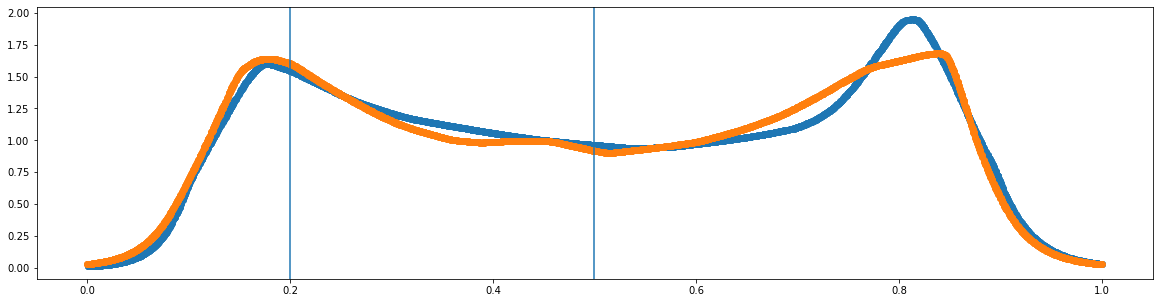

In [32]:
plt.figure(figsize=(20, 5))
for i in range(2):
    z, p = sw_list[-1].posterior(i)
    plt.axvline(z0[i])
    plt.scatter(z, p)

In [33]:
sw_list[-1].trainNd([[0, 1]], max_epochs = 100, nbatch = 16)

Start training
LR iteration 0
Total epochs: 11
Validation losses: [1.8844049610197544, 1.8099627271294594, 1.8462970573455095, 1.7184006832540035, 1.6849155835807323, 1.7260084673762321, 1.7722673527896404, 1.6783578861504793, 1.8292435333132744, 1.6949361599981785, 1.8811514843255281]
LR iteration 1
Total epochs: 7
Validation losses: [1.673286885023117, 1.6682217884808779, 1.6195160448551178, 1.6027596332132816, 1.685420647263527, 1.6422695145010948, 1.6050531323999166]
LR iteration 2
Total epochs: 8
Validation losses: [1.6873507183045149, 1.640712633728981, 1.6178398672491312, 1.6074263267219067, 1.6061065532267094, 1.681717723608017, 1.6284025255590677, 1.6710435152053833]


(0.0, 1.0)

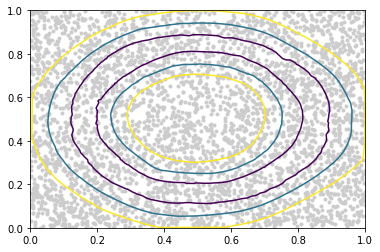

In [34]:
zgrid, lnLgrid = sw_list[-1].posterior([0, 1])
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
plt.tricontour(zgrid[:,0], zgrid[:,1], (-lnLgrid+max_lnL)*2, levels = [1, 4, 9])
plt.xlim([0, 1])
plt.ylim([0, 1])